## functions

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore,ttest_ind,ttest_rel,pearsonr,spearmanr,ttest_1samp,wilcoxon

sns.set(font_scale=1.5,style="white")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### load data

In [24]:
def fill_nan(df):
    df.columns = range(df.shape[1])
    nan_locations = df.isna().stack()[df.isna().stack()].index.tolist()
    for loc in nan_locations:
        row, col = loc
        if col == 0:  
            df.iloc[row, col] = np.nanmean(df.iloc[row, col+1:col+3])
        elif col == df.shape[1] - 1:  
            df.iloc[row, col] = np.nanmean(df.iloc[row, col-2:col])
        else:  
            df.iloc[row, col] = np.nanmean(df.iloc[row, col-1:col+2])
    
    df.columns = df.columns.astype(str)
    return df

def check_df(df):
    cols = df.columns
    df = fill_nan(df)
    df.columns = cols
    return df
    
def read_bold(sub,run_label):
    bold_ctx = pd.read_csv(os.path.join(bold_path,sub,run_label,schaefer+'.csv'))
    bold_sub = pd.read_csv(os.path.join(bold_path,sub,run_label,'hcp.csv'))
    bold = pd.concat([bold_ctx,bold_sub],axis=1)
    bold = check_df(bold)
    return bold

In [3]:
demo_info = pd.read_csv('/data/dy/TIS_MDD/demo_info.csv',index_col=0)
demo_info['sub_id'] = demo_info.index
demo_info['sex_id'] = [1 if i=='M' else 0 for i in demo_info['sex']]

def fun_add_demo_time(data,run_label):
    data = pd.concat([data,demo_info],axis=1)
    data['time'] = [run_label for i in range(data.shape[0])]
    data = data.dropna(axis=0)
    return data

def fun_concat(data1,data2):
    df = pd.concat([data1,data2],axis=1)
    df = df.dropna(axis=0)
    cut_ = int(df.shape[1]/2)
    data = pd.concat([df.iloc[:,:cut_],df.iloc[:,cut_:]])
    return data

### dissimilarity

In [5]:
import statsmodels.api as sm

def get_dissim(run_label_2):
    run_label_1 = 'baseline'
    result = []
    index_ls = []
    for sub in sub_ls:
        if(len(os.listdir(os.path.join(bold_path,sub,run_label_2)))!=0):
            
            bold_1 = read_bold(sub,run_label_1);bold_2 = read_bold(sub,run_label_2)
            fc_1 = np.corrcoef(bold_1.T);fc_2 = np.corrcoef(bold_2.T)
            between = np.array([1-pearsonr(fc_1[i,:],fc_2[i,:])[0] for i in range(n_roi)])
            
            third1 = int(bold_1.shape[0]/3);third2 = int(bold_1.shape[0]*2/3)
            fc_11 = np.corrcoef(bold_1.iloc[:third1,:].T);fc_12 = np.corrcoef(bold_1.iloc[third2:,:].T)
            within1 = np.array([1-pearsonr(fc_11[i,:],fc_12[i,:])[0] for i in range(n_roi)])
            
            third1 = int(bold_2.shape[0]/3);third2 = int(bold_2.shape[0]*2/3)
            fc_21 = np.corrcoef(bold_2.iloc[:third1,:].T);fc_22 = np.corrcoef(bold_2.iloc[third2:,:].T)
            within2 = np.array([1-pearsonr(fc_21[i,:],fc_22[i,:])[0] for i in range(n_roi)])
            
            within = (within1+within2)/2
            
            within = sm.add_constant(within)
            model = sm.OLS(between, within).fit()
            dissim = model.resid + model.params[0]
            
            result.append(dissim)
            index_ls.append(sub)
    return pd.DataFrame(result,index=index_ls,columns=roi_ls)

### significant dissimilarity

In [4]:
import statsmodels.api as sm

def BH_correct(p_values):
    p_values = np.array(p_values)
    return  sm.stats.multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

In [15]:
def get_change_region(run_label_2):
    dissim = get_dissim(run_label_2)

    df = pd.concat([dissim,demo_info],axis=1).dropna(axis=0)
    Y = np.array(df[dissim.columns]);x = np.array(df[['age','sex_id']])
    x = sm.add_constant(x);model = sm.OLS(Y, x).fit();Y_resid = model.resid + model.params[0]
    dissim = pd.DataFrame(Y_resid,index=dissim.index,columns=dissim.columns)
    
    result = wilcoxon(dissim)
    p_values = result.pvalue
    

    df = pd.DataFrame(p_values,index=np.array(roi_ls),columns=['p_values'])
    df['ICN'] = np.array(icn_ls)
    df['FDR'] = BH_correct(df['p_values'])
    df = df[df['FDR']<=0.05]
    change_ls = df.index.tolist()
    change_region = np.array([True if i in change_ls else False for i in roi_ls])
    return change_region

In [62]:
def count_region(df):
    result = pd.DataFrame(np.zeros(len(RSNs)),index=RSNs,columns=['n'])
    for rsn in RSNs:
        result.loc[rsn,'n'] = df[df['ICN']==rsn].shape[0]
    result['n'] /= np.sum(result['n'])
    result['n'] *= 100
    return result

def barplot_change_region(change_region,label=''):
    df = pd.DataFrame(change_region,columns=['change'])
    df['ICN']=icn_ls[:-19];df=df[df['change']==True]
    df = count_region(df);df['label'] = ICN_ticks

    unique_indices = df.index.unique()
    color_palette = ['#E6194B','#3CB44B','#FFE119','#4363D8','#F58231','#911EB4','#42D4F4']
    color_mapping = dict(zip(unique_indices, color_palette))
    
    df_sorted = df.sort_values('n', ascending=False)
    print(df_sorted)
    plt.figure(figsize=(8,4),dpi=300)
    sns.barplot(data=df_sorted, y='n', x=df_sorted.index, 
                palette=[color_mapping[idx] for idx in df_sorted.index])
    plt.xticks([i for i in range(len(ICN_ticks))],df_sorted['label'],fontsize=22);plt.ylabel(label,fontsize=25)

### brain plotting

In [10]:
import warnings
warnings.filterwarnings("ignore", message="The dist attribute was deprecated in Matplotlib 3.6")

In [26]:
from nilearn import datasets, plotting, surface
from nilearn.image import new_img_like, get_data
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap, ListedColormap

def plot_nilearn_change(metric_values, alpha=0.7,
                 dist=8.5,threshold=None, label=None,
                 title=None,cbar_label='Z-Score',vmin=-2,vmax=3,cbar_step=1,cmap_color='RdPu',ylabel=None):
    atlas_data = get_data(schaefer_atlas.maps)
    metric_map = np.zeros(atlas_data.shape)
    for roi_val in np.unique(atlas_data):
        if roi_val == 0:  
            continue
        metric_map[atlas_data == roi_val] = metric_values[int(roi_val)-1]
    metric_img = new_img_like(schaefer_atlas.maps, metric_map)
    
    if(threshold==None):
        threshold = vmin
    
    texture_left = surface.vol_to_surf(metric_img, fsaverage.pial_left)
    texture_right = surface.vol_to_surf(metric_img, fsaverage.pial_right)
    
    fig = plt.figure(figsize=(28, 5),dpi=300)
    gs = GridSpec(2, 7, figure=fig, width_ratios=[0.001,1+alpha, 1, alpha, alpha, 1, 1+alpha], height_ratios=[1, 0.07], wspace=0,hspace=0)
    if title is not None:
        fig.suptitle(title, fontsize=45, y=1.05)

    
    custom_cmap = plt.get_cmap(cmap_color)
    sm = ScalarMappable(norm=Normalize(vmin=threshold, vmax=vmax), cmap=custom_cmap)
    sm.set_array([])
    bg_params = {'bg_map': fsaverage.sulc_left, 'darkness': 0.7}
    
    ax0 = fig.add_subplot(gs[0, 0])
    if ylabel is not None:
        ax0.set_ylabel(ylabel, fontsize=45)
        ax0.set_xticks([])  
        ax0.set_yticks([])  
        ax0.spines['top'].set_visible(False) 
        ax0.spines['right'].set_visible(False)  
        ax0.spines['bottom'].set_visible(False)  
        ax0.spines['left'].set_visible(False)  
    
    ax1 = fig.add_subplot(gs[0, 1], projection='3d')
    plot1 = plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left', view='lateral',
        axes=ax1, cmap=custom_cmap, vmax=vmax, vmin=threshold, **bg_params, colorbar=False, title='L')
    ax1.dist = dist
    ax1.title.set_size(45); ax1.title.set_position([0.125, 1])
    
    ax2 = fig.add_subplot(gs[0, 2:4], projection='3d')
    plot2 = plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left', view='medial',
        axes=ax2, cmap=custom_cmap, vmax=vmax, vmin=threshold, **bg_params, colorbar=False)
    ax2.dist = dist
    
    ax3 = fig.add_subplot(gs[0, 6], projection='3d')
    plot3 = plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right', view='lateral',
        axes=ax3, cmap=custom_cmap, vmax=vmax, vmin=threshold, bg_map=fsaverage.sulc_right, darkness=0.7, colorbar=False, title='R') 
    ax3.dist = dist
    ax3.title.set_size(45); ax3.title.set_position([0.875, 1])

    ax4 = fig.add_subplot(gs[0, 4:6], projection='3d')
    plot4 = plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right', view='medial',
        axes=ax4, cmap=custom_cmap, vmax=vmax, vmin=threshold, bg_map=fsaverage.sulc_right, darkness=0.7, colorbar=False)
    ax4.dist = dist
    
    cax = fig.add_subplot(gs[1, 3:5])
    sm = ScalarMappable(norm=Normalize(vmin=threshold, vmax=vmax), cmap=plt.get_cmap(cmap_color))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label(cbar_label, size=45)
    if label is None:
        label = np.arange(threshold,vmax+cbar_step,cbar_step)
        label = [round(i,1) for i in label]
        ticks = label.copy()
        ticks[0] = threshold; ticks[-1] = vmax
    cbar.set_ticks(ticks=ticks, labels=label,fontsize=35)  
    
    plt.show()

## Plotting

In [54]:
c_RdPu = plt.get_cmap('RdPu')
c_GnBu = plt.get_cmap('GnBu')
c_vir = plt.get_cmap('viridis')
c_Reds = plt.get_cmap('Reds')

In [55]:
time_ls = ['5th_201','5th_301','5th_after','4weeks']
day_ls = ['D5-act1','D5-act2','D5-post','W4']

In [56]:
schaefer = '100'
schaefer_n = int(schaefer)
#################
atlas = pd.read_csv(f"/data/dy/atlas/schaefer{schaefer}x7_MNI.csv")
RSNs = ['Vis','SomMot','DorsAttn','SalVentAttn','Limbic','Cont','Default']
ICNs = RSNs+['Sub']
icn_ls = atlas['ICN'].tolist()+['Sub' for _ in range(19)]
n_roi = int(schaefer)+19

upper_mask = np.triu(np.ones((n_roi, n_roi), dtype=bool), k=1)

bold_path = '/data/dy/TIS_MDD/BOLD'
sub_ls = os.listdir(bold_path)

roi_ls = read_bold(sub_ls[0],'baseline').columns.tolist()
atlas['Name'] = roi_ls[:-19]

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=int(schaefer), yeo_networks=7)
fsaverage = datasets.fetch_surf_fsaverage()

dissim min=0.00,max=0.23


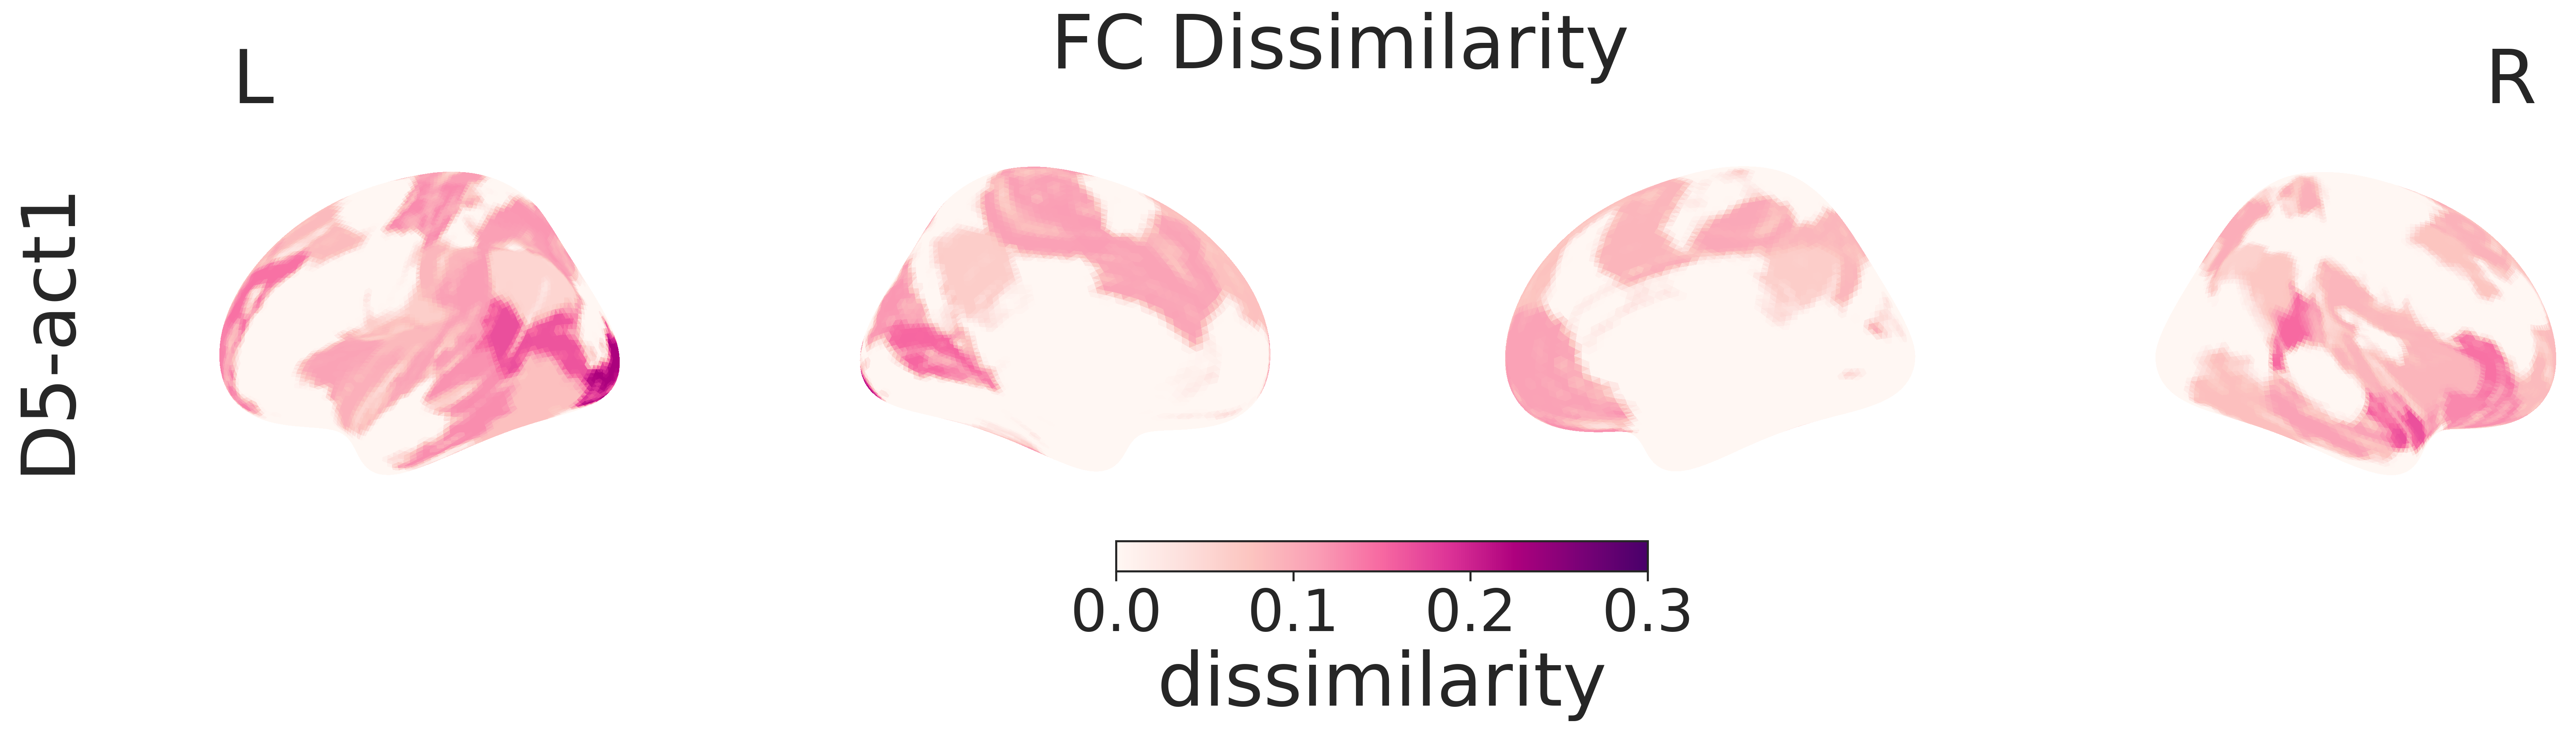

dissim min=0.00,max=0.27


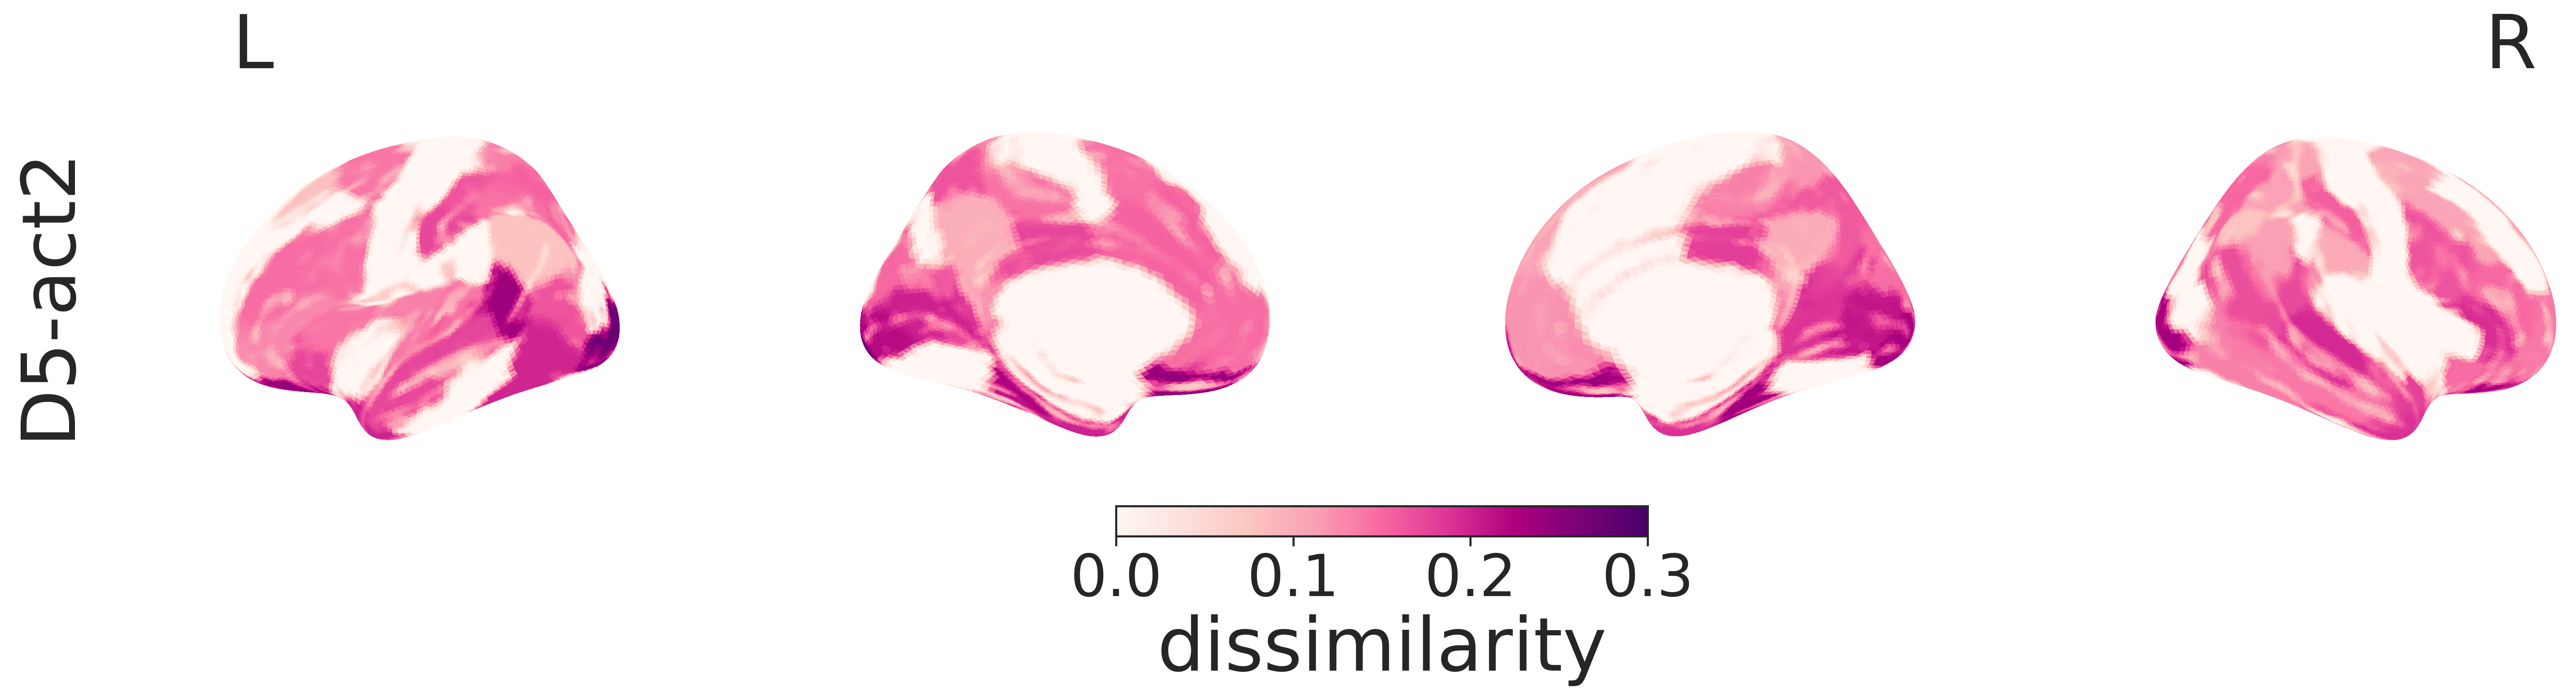

dissim min=0.00,max=0.23


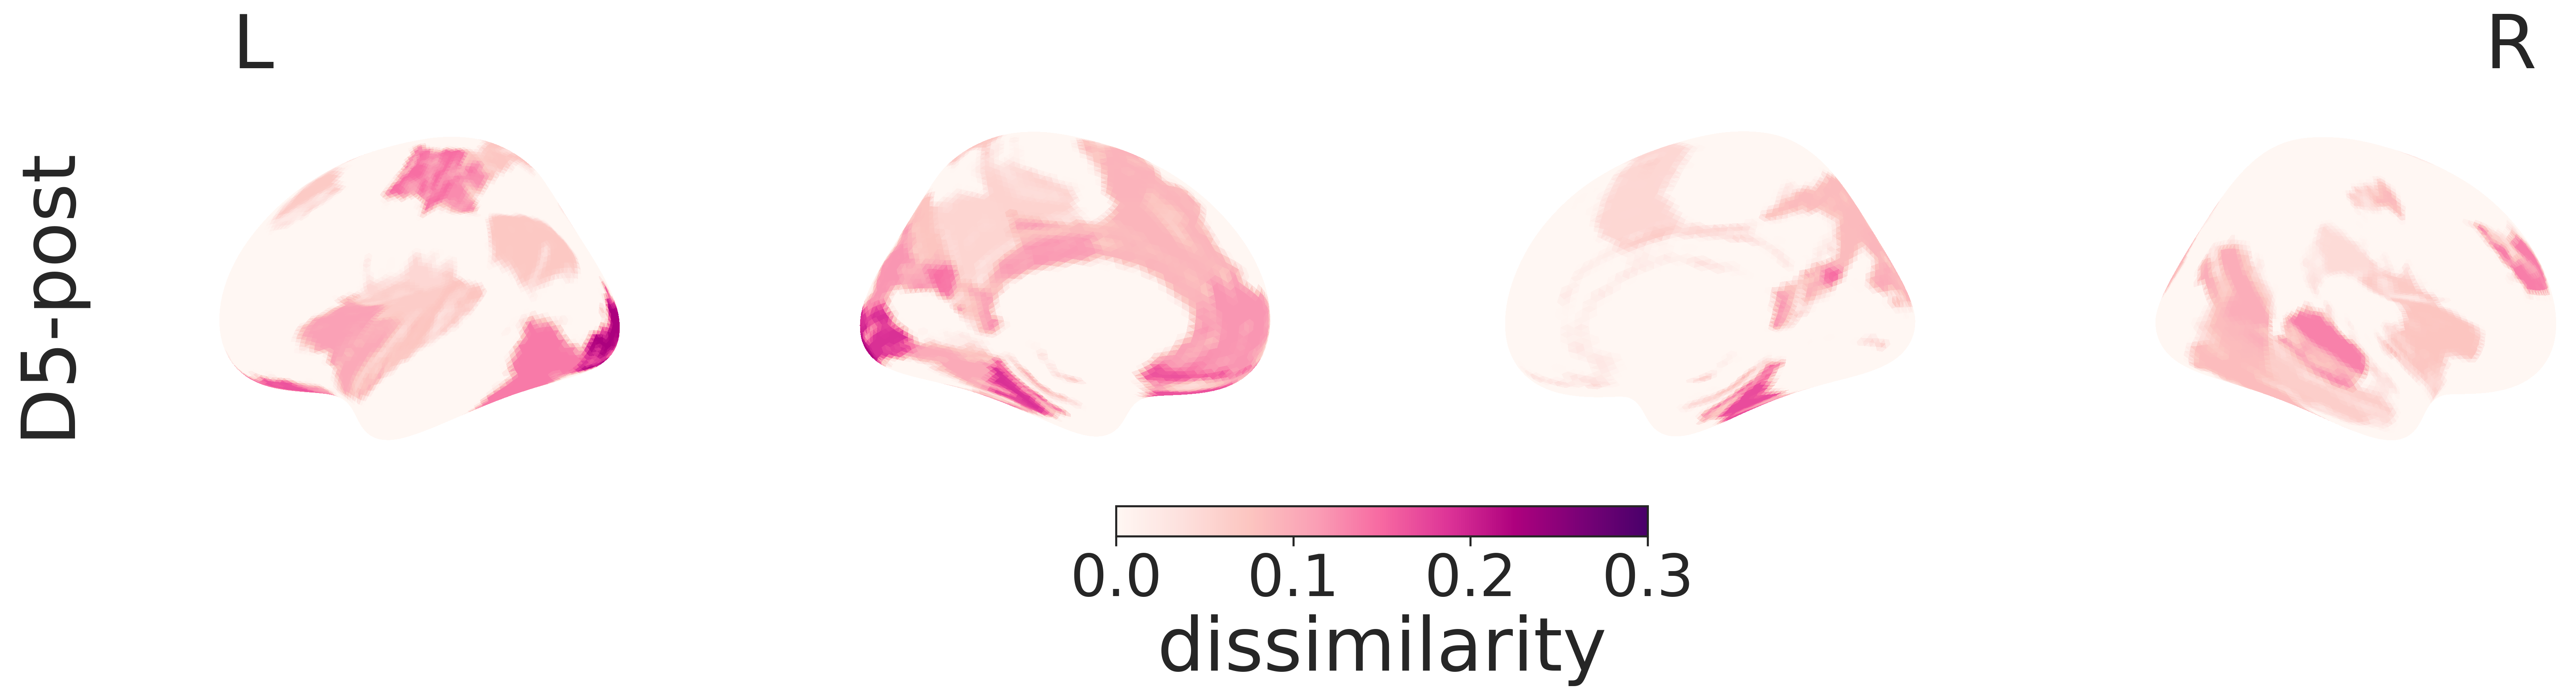

dissim min=0.00,max=0.18


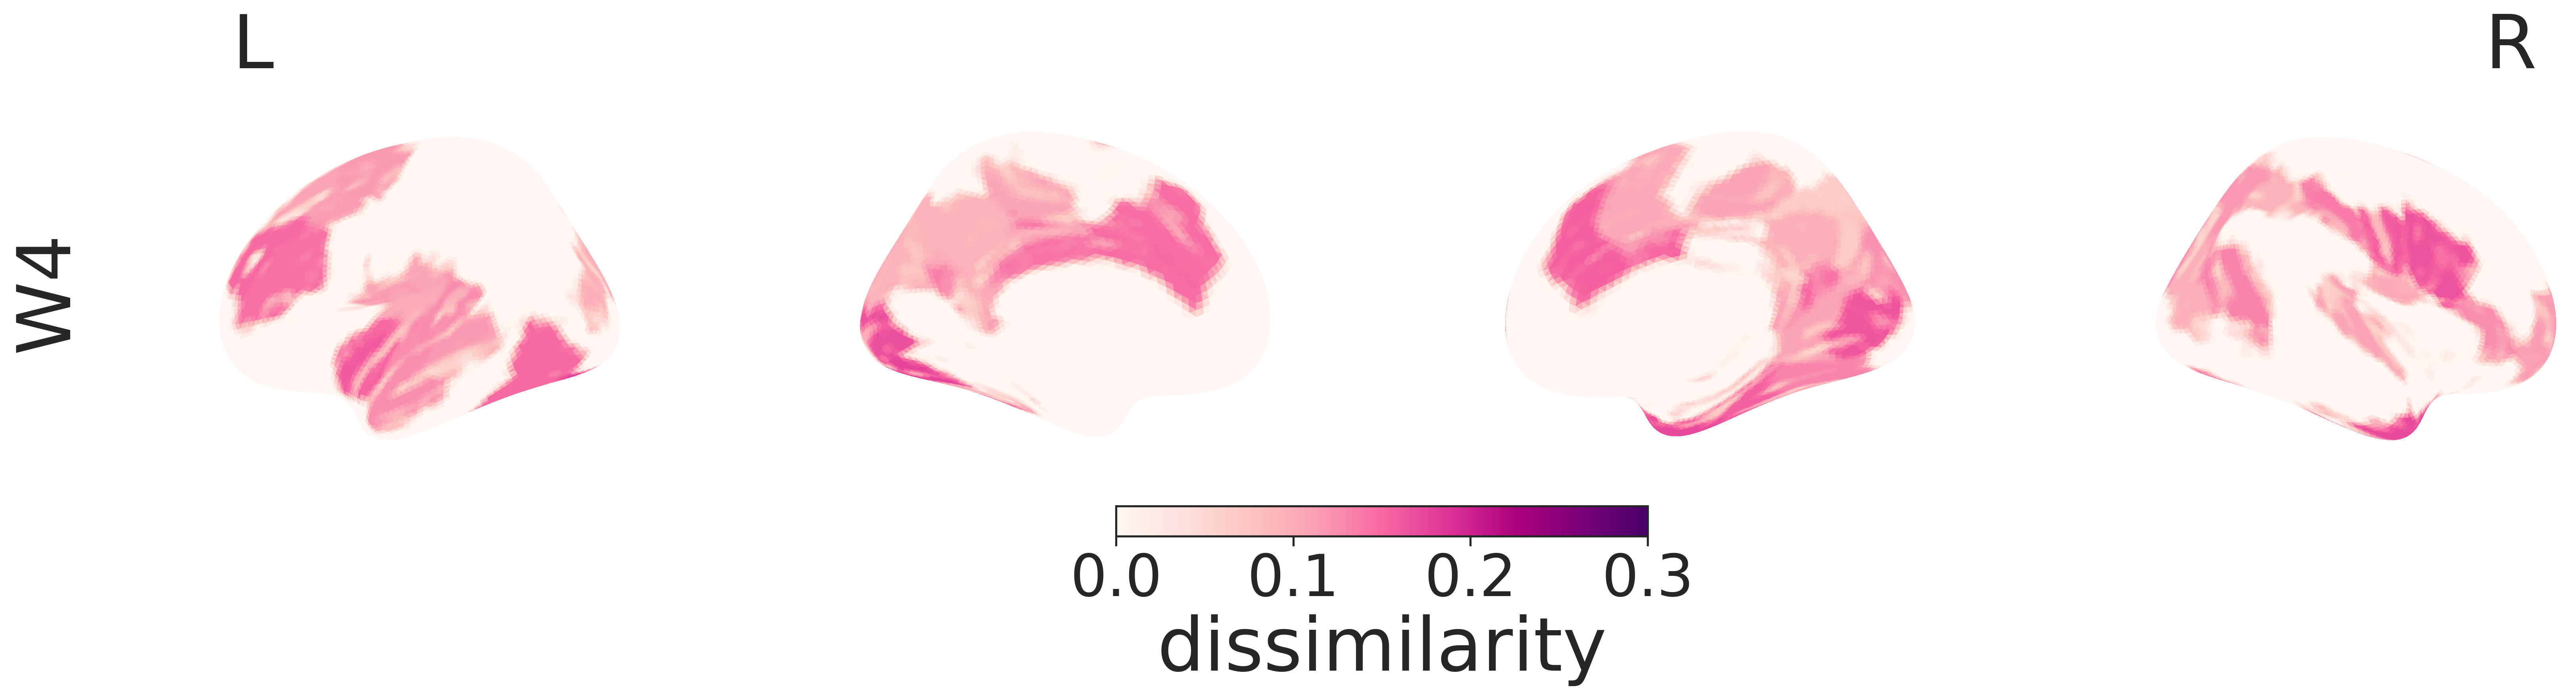

In [60]:
title='FC Dissimilarity'
for i in range(len(time_ls)):
    dissim = np.mean(get_dissim(time_ls[i]),0)[:schaefer_n];process = dissim.copy()
    change_region = get_change_region(time_ls[i])[:schaefer_n]
    dissim[~change_region]=0
    
    print(f"dissim min={np.min(dissim):.2f},max={np.max(dissim):.2f}")
    plot_nilearn_change(dissim,
                        threshold=0,vmin=-1,vmax=0.3,cbar_step=0.1,
                        ylabel=day_ls[i],title=title,
                        cbar_label = 'dissimilarity')
    title = ''

In [58]:
ICN_ticks = ['VIS','SN','DAN','VAN','LMB','FPN','DMN']

                     n label
Default      32.692308   DMN
SalVentAttn  21.153846   VAN
SomMot       15.384615    SN
Vis           9.615385   VIS
Cont          9.615385   FPN
DorsAttn      7.692308   DAN
Limbic        3.846154   LMB
                     n label
Default      28.571429   DMN
DorsAttn     21.428571   DAN
Vis          17.142857   VIS
Cont         12.857143   FPN
SalVentAttn  10.000000   VAN
Limbic        5.714286   LMB
SomMot        4.285714    SN
                     n label
Vis          20.512821   VIS
SalVentAttn  20.512821   VAN
Default      20.512821   DMN
SomMot       15.384615    SN
DorsAttn     10.256410   DAN
Cont         10.256410   FPN
Limbic        2.564103   LMB
                     n label
Vis          22.222222   VIS
Default      20.000000   DMN
DorsAttn     15.555556   DAN
SomMot       13.333333    SN
SalVentAttn  13.333333   VAN
Cont         13.333333   FPN
Limbic        2.222222   LMB


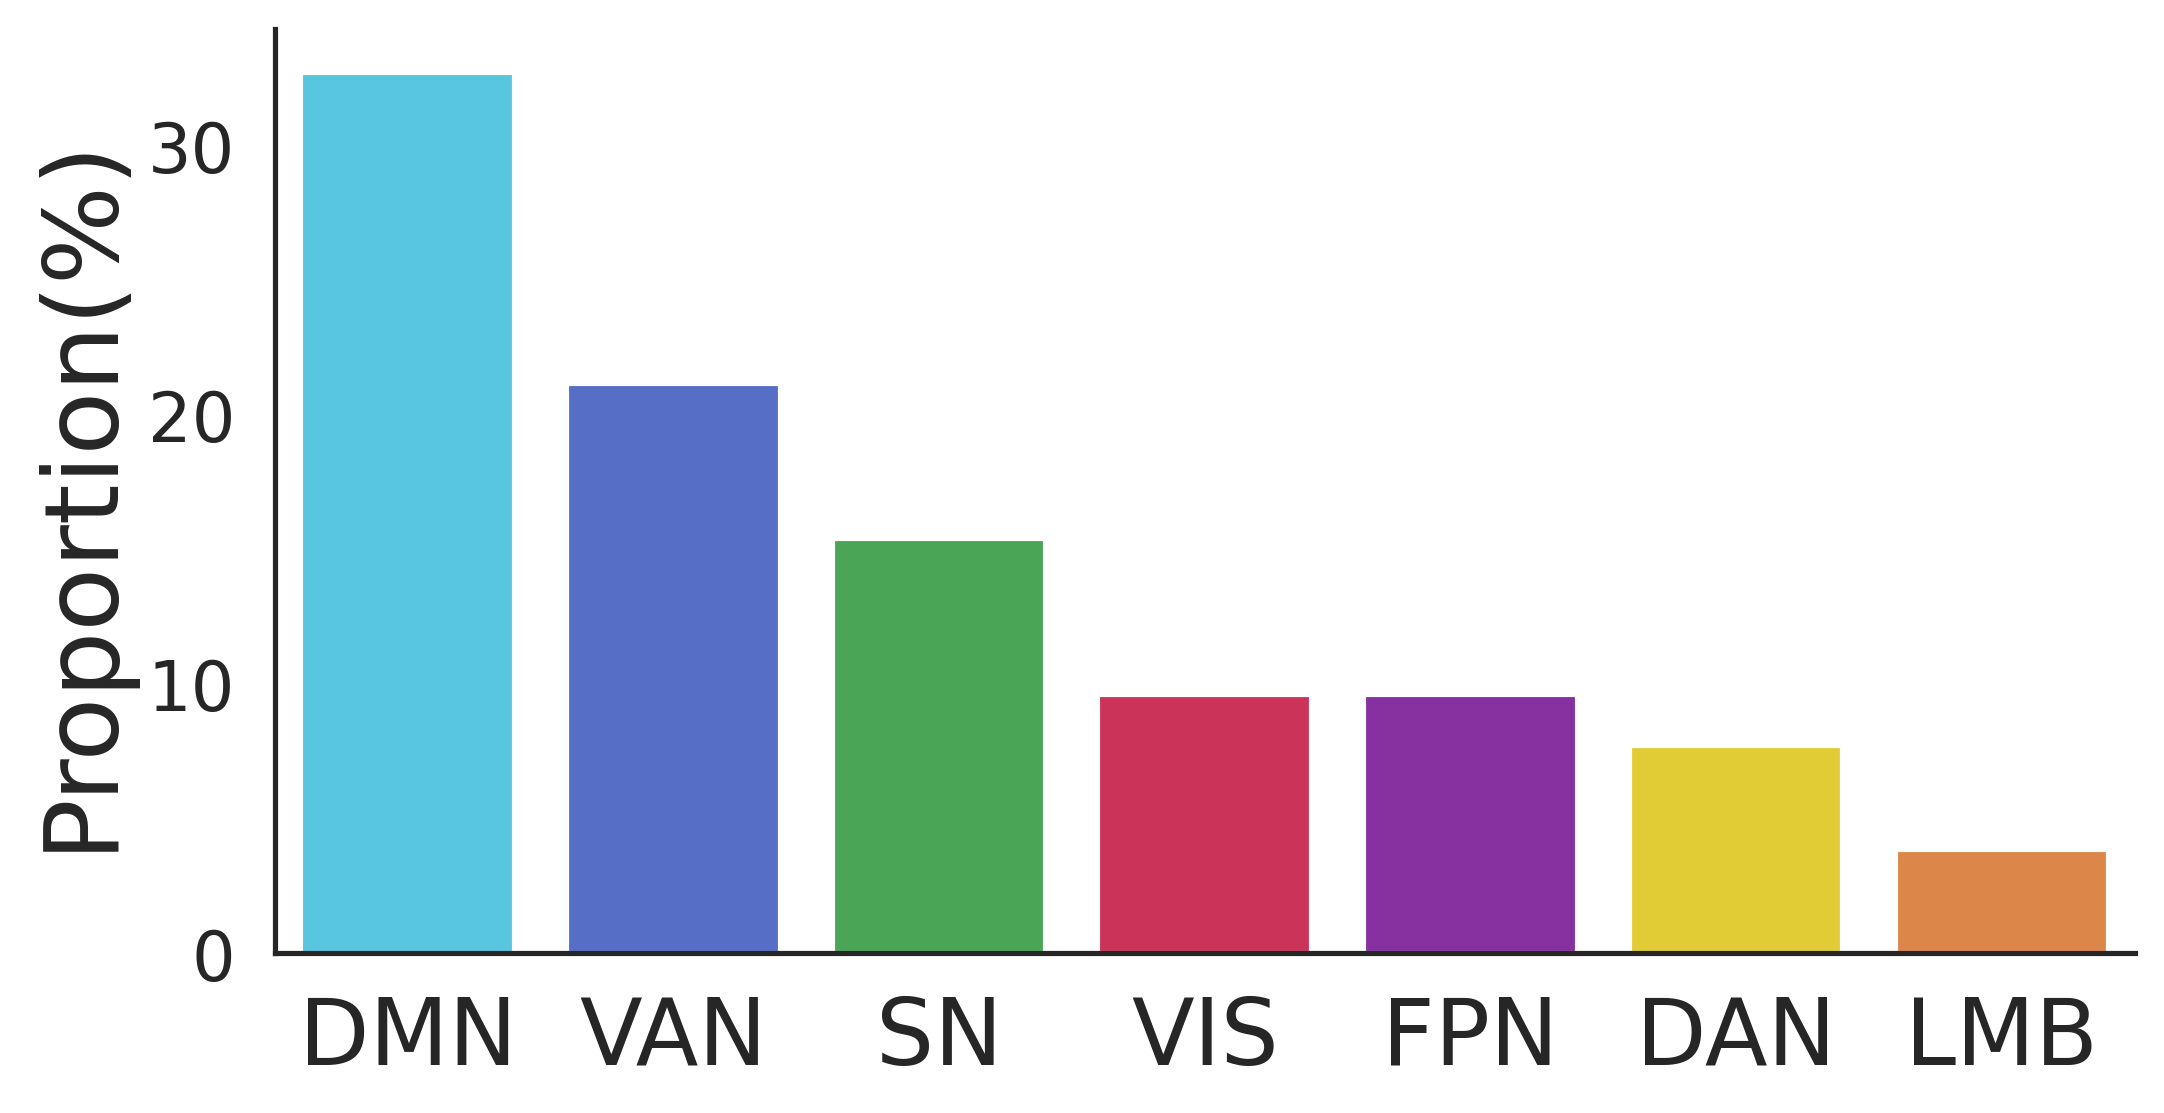

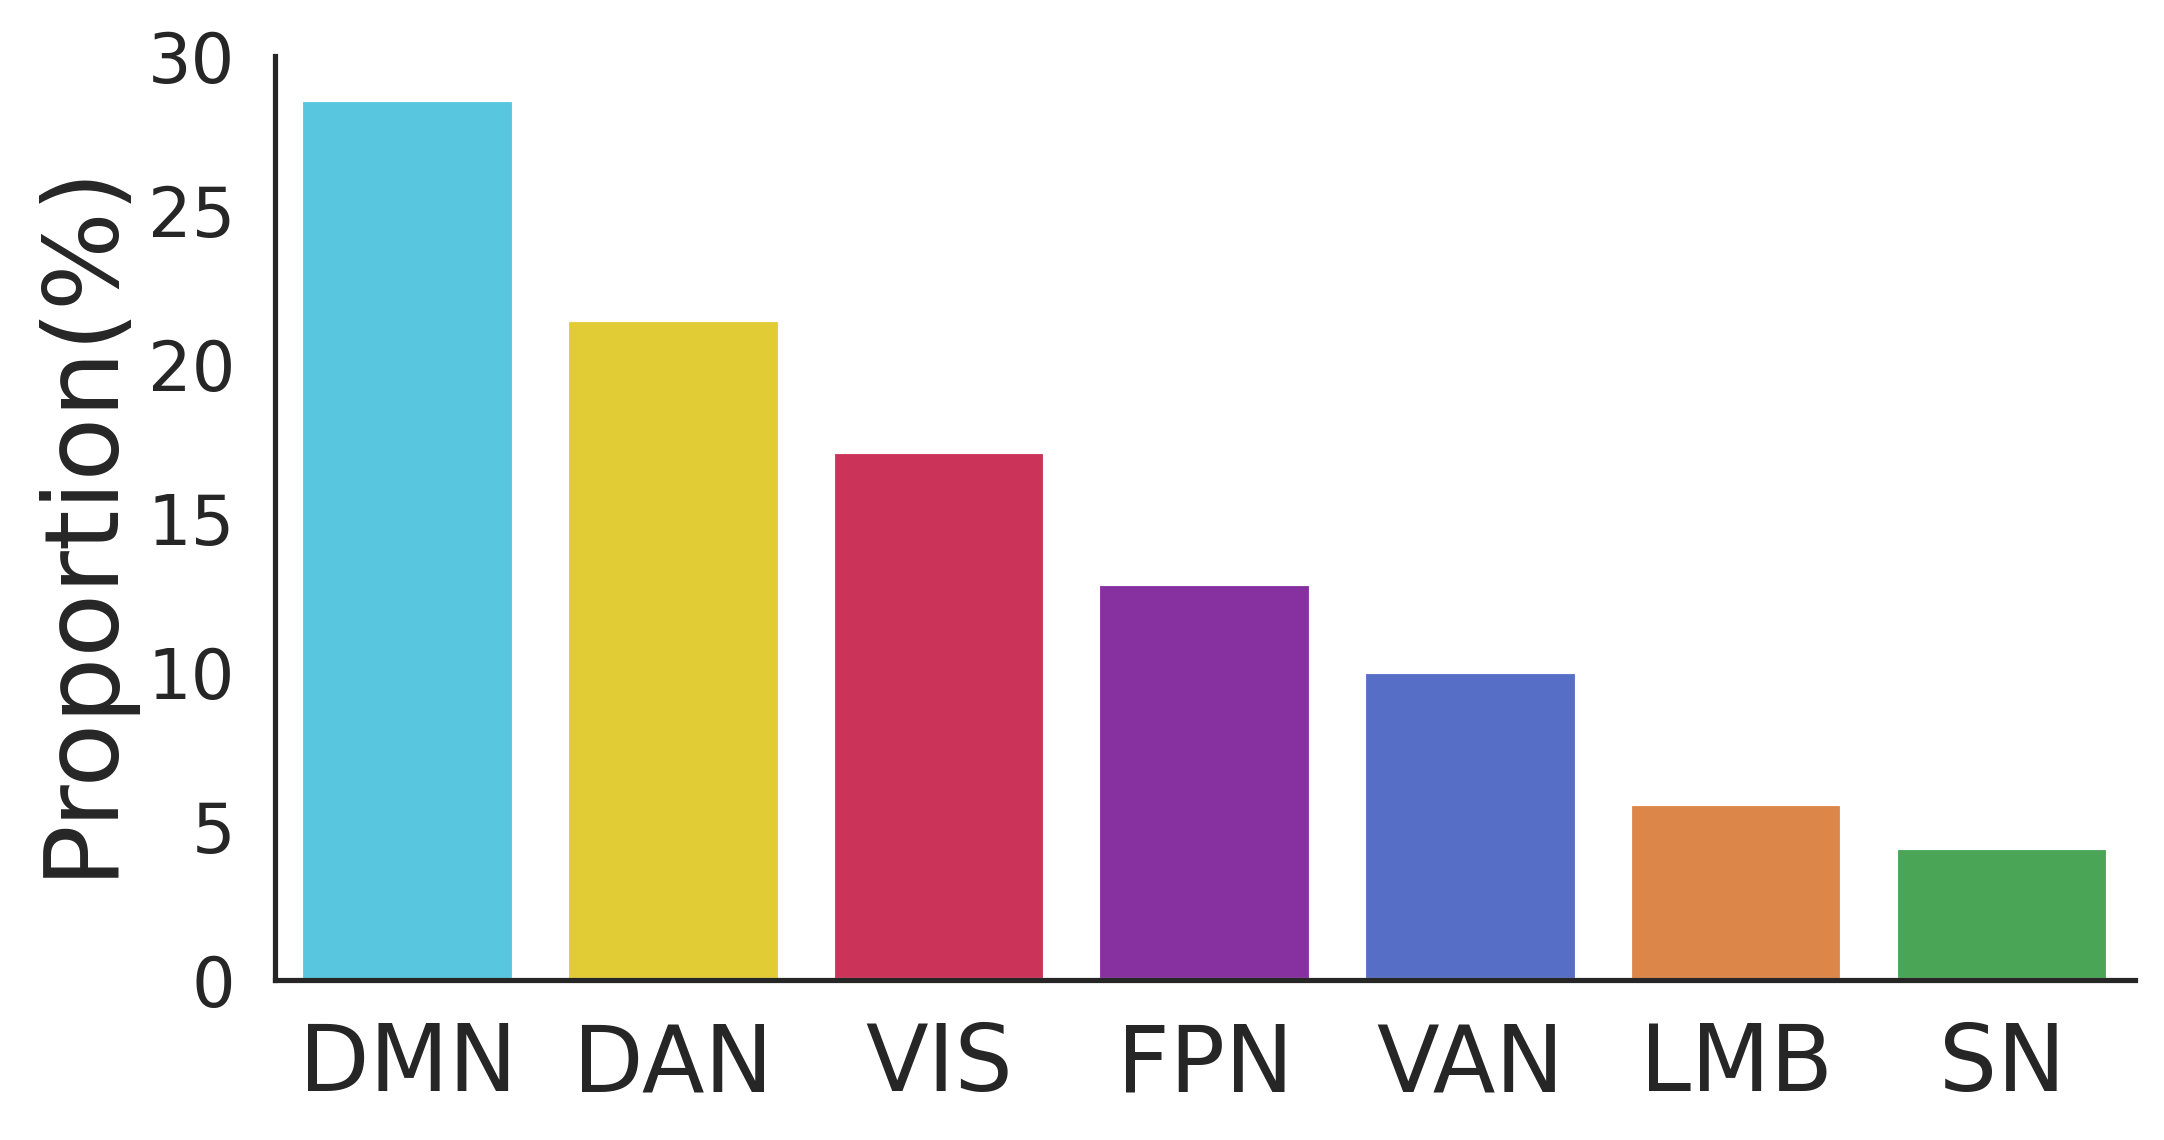

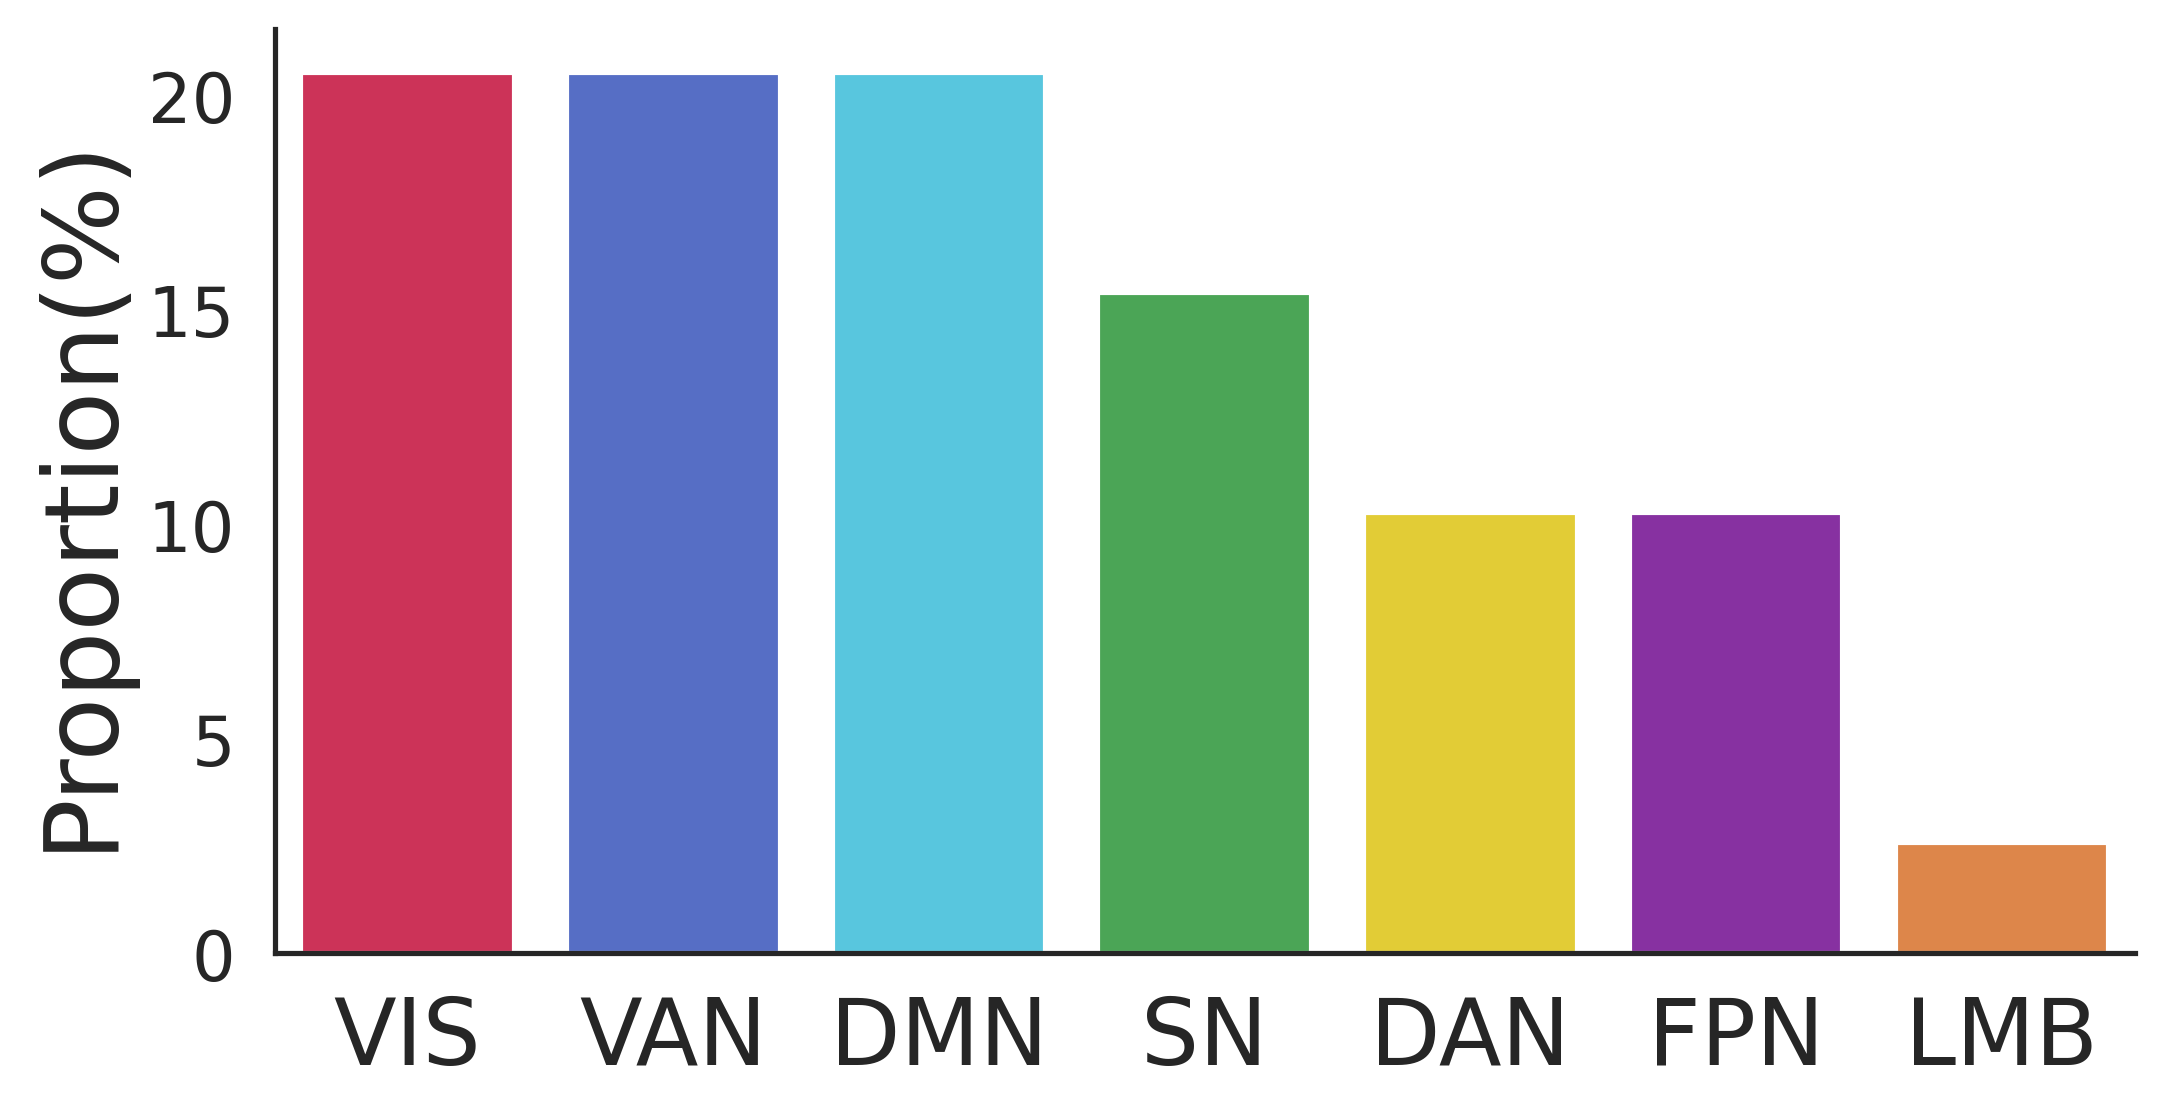

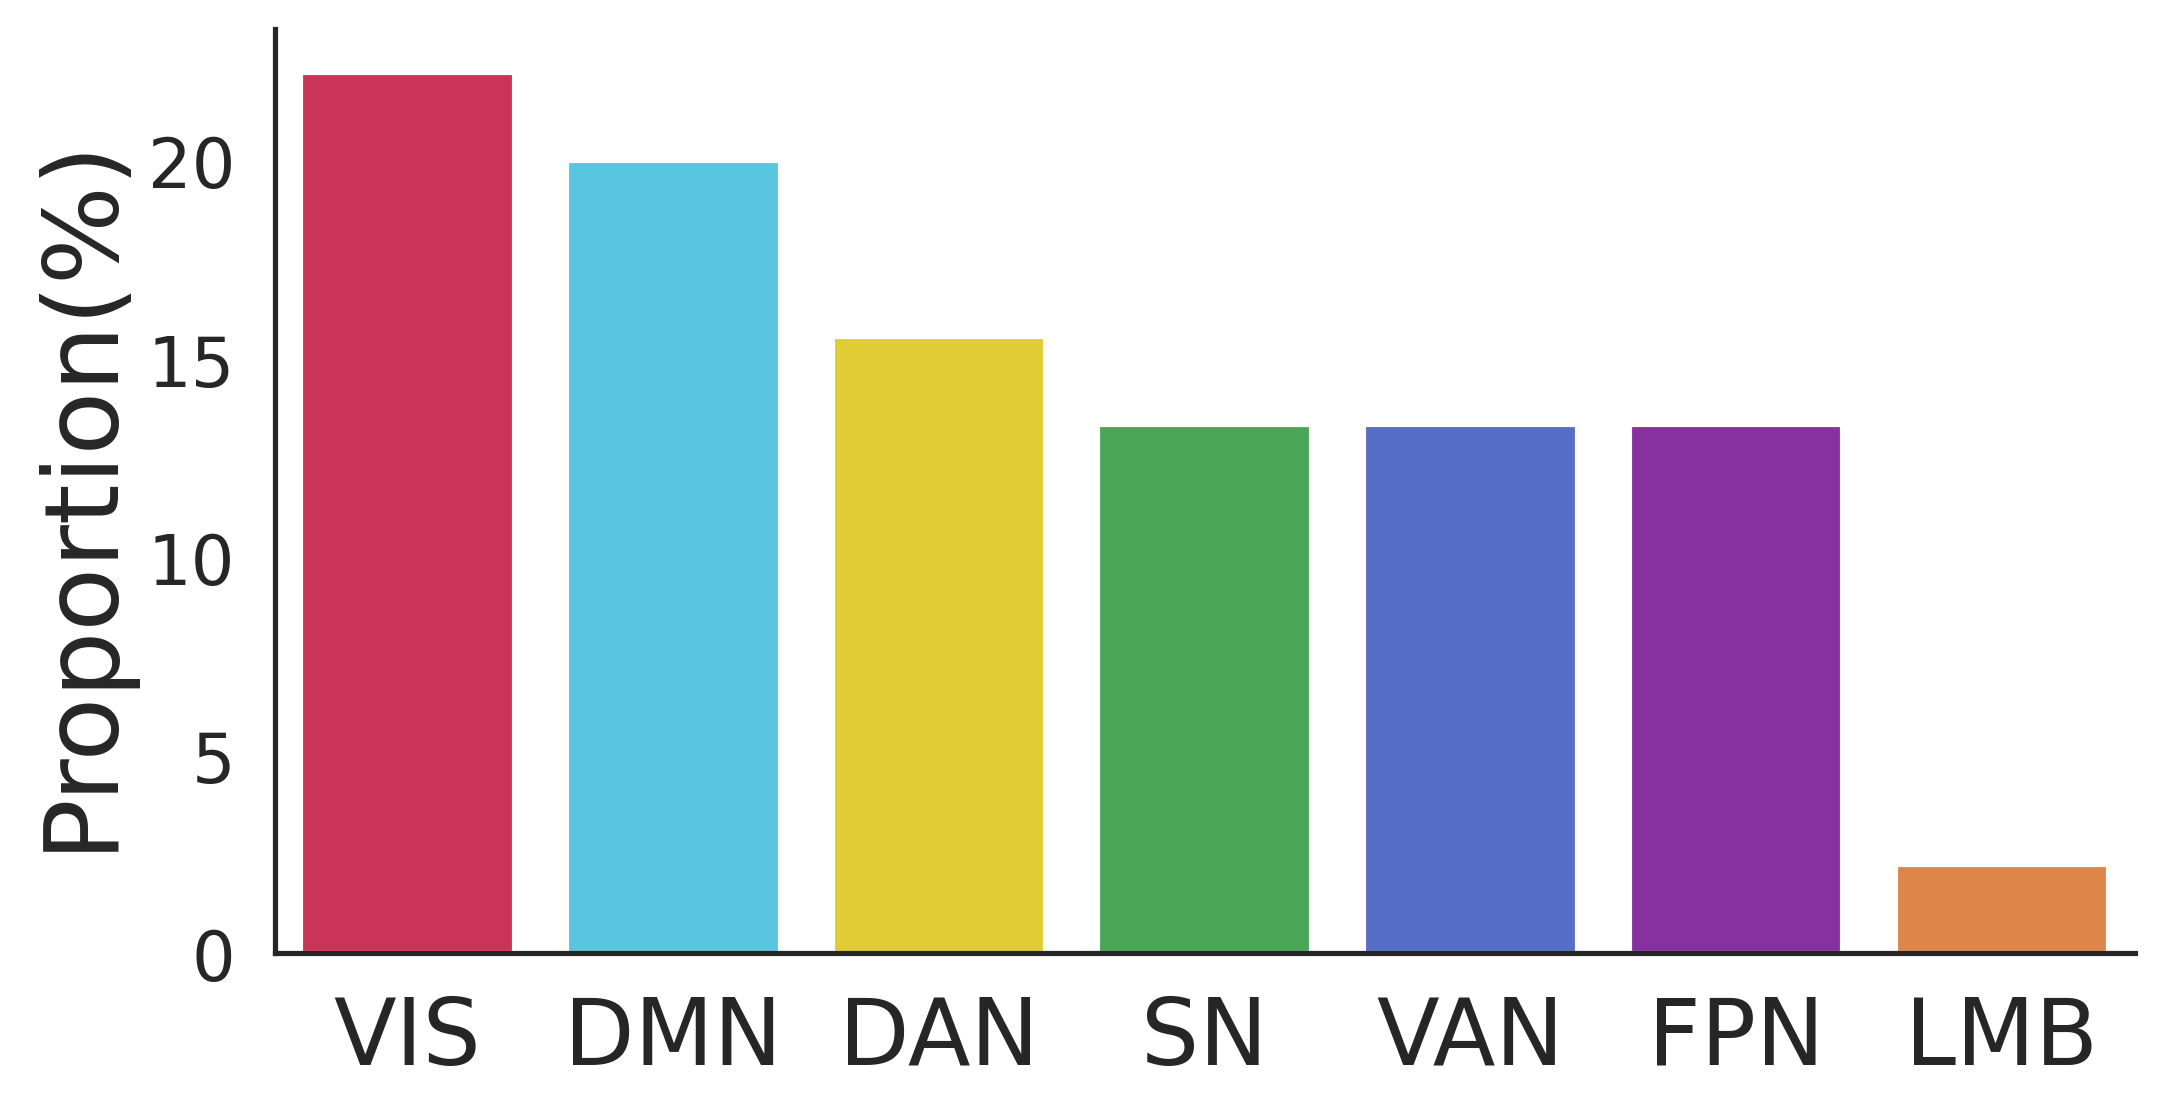

In [63]:
for i in range(len(time_ls)):
    change_region = get_change_region(time_ls[i])[:int(schaefer)]
    barplot_change_region(change_region,f"Proportion(%)")
    plt.title(f"",fontsize=20)